<a href="https://colab.research.google.com/github/Dhruv-2020EE30592/Extra-Notebooks/blob/main/HateMemeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm

In [2]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

In [3]:
data = torch.load('/content/drive/MyDrive/combined_embeddings.pt', weights_only=True)
print(f'data type: {type(data)}')
print(f'size of data: {len(data)}')
for key in data[0].keys():
  print(f"{key}: {type(data[0][key])} {data[0][key].size() if torch.is_tensor(data[0][key]) else ' '}")

data type: <class 'list'>
size of data: 3544
image: <class 'str'>  
image_embedding: <class 'torch.Tensor'> torch.Size([1, 512])
caption_embedding: <class 'torch.Tensor'> torch.Size([1, 512])
meme_text_embedding: <class 'torch.Tensor'> torch.Size([1, 512])
vqa_embeddings: <class 'torch.Tensor'> torch.Size([8, 1, 512])
label: <class 'int'>  


# Using attention

In [4]:
class MemeDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        image_emb = sample['image_embedding']
        caption_emb = sample['caption_embedding']
        meme_text_emb = sample['meme_text_embedding']
        vqa_emb_0 = sample['vqa_embeddings'][0]
        vqa_emb_1 = sample['vqa_embeddings'][1]
        vqa_emb_2 = sample['vqa_embeddings'][2]
        vqa_emb_3 = sample['vqa_embeddings'][3]
        vqa_emb_4 = sample['vqa_embeddings'][4]
        vqa_emb_5 = sample['vqa_embeddings'][5]
        vqa_emb_6 = sample['vqa_embeddings'][6]
        vqa_emb_7 = sample['vqa_embeddings'][7]
        label = sample['label']

        if self.transform:
            pass

        return image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7, label

dataset = MemeDataset(data)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
index = 0
data_point = train_dataset[index]

image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7, label = data_point

print("Index:", index)
print("Image Embedding:", image_emb.shape)
print("Caption Embedding:", caption_emb.shape)
print("Meme Text Embedding:", meme_text_emb.shape)
print("VQA Embeddings:")
print("  VQA 0:", vqa_emb_0.shape)
print("  VQA 1:", vqa_emb_1.shape)
print("  VQA 2:", vqa_emb_2.shape)
print("  VQA 3:", vqa_emb_3.shape)
print("  VQA 4:", vqa_emb_4.shape)
print("  VQA 5:", vqa_emb_5.shape)
print("  VQA 6:", vqa_emb_6.shape)
print("  VQA 7:", vqa_emb_7.shape)
print("Label:", label)

Index: 0
Image Embedding: torch.Size([1, 512])
Caption Embedding: torch.Size([1, 512])
Meme Text Embedding: torch.Size([1, 512])
VQA Embeddings:
  VQA 0: torch.Size([1, 512])
  VQA 1: torch.Size([1, 512])
  VQA 2: torch.Size([1, 512])
  VQA 3: torch.Size([1, 512])
  VQA 4: torch.Size([1, 512])
  VQA 5: torch.Size([1, 512])
  VQA 6: torch.Size([1, 512])
  VQA 7: torch.Size([1, 512])
Label: 0


In [18]:
# Acc: 84.7
# class AttentionModule(nn.Module):
#     def __init__(self, input_dim):
#         super(AttentionModule, self).__init__()
#         self.attention_weights = nn.Parameter(torch.rand(input_dim))

#     def forward(self, image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7):
#         embeddings = torch.stack([image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7], dim=1)

#         attention_scores = torch.matmul(embeddings, self.attention_weights)
#         attention_scores = F.softmax(attention_scores, dim=1)
#         weighted_sum = torch.sum(attention_scores.unsqueeze(-1) * embeddings, dim=1)

#         return weighted_sum

# Acc: 87.7
# class AttentionModule(nn.Module):
#     def __init__(self, input_dim):
#         super(AttentionModule, self).__init__()
#         self.attention_layer = nn.Linear(input_dim, 1)

#     def forward(self, image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7):
#         embeddings = torch.stack([image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7], dim=1)

#         attention_scores = self.attention_layer(embeddings)
#         attention_scores = attention_scores.squeeze(-1)
#         attention_scores = F.softmax(attention_scores, dim=1)
#         weighted_sum = torch.sum(attention_scores.unsqueeze(-1) * embeddings, dim=1)

#         return weighted_sum

# 89.1
class MultiHeadAttentionModule(nn.Module):
    def __init__(self, input_dim, num_heads):
        super(MultiHeadAttentionModule, self).__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        assert self.head_dim * num_heads == input_dim, "input_dim must be divisible by num_heads"

        self.query_layer = nn.Linear(input_dim, input_dim)
        self.key_layer = nn.Linear(input_dim, input_dim)
        self.value_layer = nn.Linear(input_dim, input_dim)
        self.output_layer = nn.Linear(input_dim, input_dim)

    def forward(self, image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7):
        embeddings = torch.stack([image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7], dim=1)
        batch_size, num_embeddings, _, _ = embeddings.shape

        query = self.query_layer(embeddings)
        key = self.key_layer(embeddings)
        value = self.value_layer(embeddings)

        query = query.view(batch_size, num_embeddings, self.num_heads, self.head_dim).transpose(1, 2)
        key = key.view(batch_size, num_embeddings, self.num_heads, self.head_dim).transpose(1, 2)
        value = value.view(batch_size, num_embeddings, self.num_heads, self.head_dim).transpose(1, 2)

        attention_scores = torch.matmul(query, key.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attention_scores = F.softmax(attention_scores, dim=-1)
        weighted_value = torch.matmul(attention_scores, value)
        weighted_value = weighted_value.transpose(1, 2).contiguous().view(batch_size, num_embeddings, self.input_dim)
        output = self.output_layer(weighted_value)
        weighted_sum = torch.sum(output, dim=1)

        return weighted_sum

# class AttentionBasedModel(nn.Module):
#     def __init__(self, input_dim=512, hidden_dim=256, output_dim=1):
#         super(AttentionBasedModel, self).__init__()
#         self.attention_module = AttentionModule(input_dim)
#         self.fc = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, output_dim),
#             nn.Sigmoid()
#         )

#     def forward(self, image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7):
#         aggregated_embedding = self.attention_module(image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7)
#         output = self.fc(aggregated_embedding)
#         return output

class AttentionBasedModel(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=256, output_dim=1, num_heads=8):
        super(AttentionBasedModel, self).__init__()
        self.attention_module = MultiHeadAttentionModule(input_dim, num_heads)
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Sigmoid()
        )

    def forward(self, image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7):
        aggregated_embedding = self.attention_module(image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7)
        output = self.fc(aggregated_embedding)
        return output

model = AttentionBasedModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epochs: 100%|███████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.93s/it]


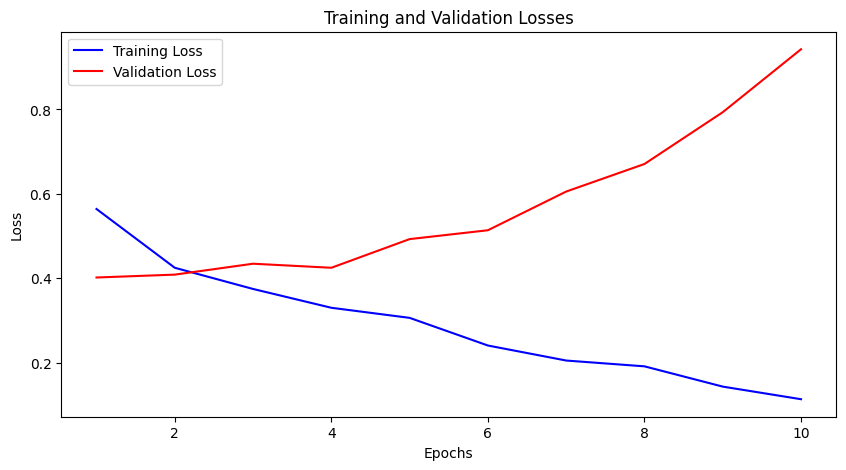

In [19]:
train_losses = []
val_losses = []

num_epochs = 10

# Example training loop
best_val_loss = float('inf')
for epoch in tqdm(range(num_epochs), desc="Epochs", ncols=100):
    model.train()
    running_loss = 0.0

    for image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7, label in train_loader:
        optimizer.zero_grad()
        outputs = model(image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7)
        loss = criterion(outputs.squeeze(), label.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7, label in val_loader:
            outputs = model(image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7)
            loss = criterion(outputs.squeeze(), label.float())
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [20]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

model.eval()
predictions = []
targets = []

with torch.no_grad():
    for image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7, label in test_loader:
        outputs = model(image_emb, caption_emb, meme_text_emb, vqa_emb_0, vqa_emb_1, vqa_emb_2, vqa_emb_3, vqa_emb_4, vqa_emb_5, vqa_emb_6, vqa_emb_7)
        predictions.append(outputs.squeeze())
        targets.append(label)

predictions = torch.cat(predictions).numpy()
targets = torch.cat(targets).numpy()

roc_auc = roc_auc_score(targets, predictions)
print(f"ROC AUC: {roc_auc}")

ROC AUC: 0.8915654238234884


# Concatenating the embeddings

In [3]:
def concat(data, i):
  image_embedding = data[i]['image_embedding']
  caption_embedding = data[i]['caption_embedding']
  meme_text_embedding = data[i]['meme_text_embedding']
  vqa_embeddings = data[i]['vqa_embeddings']
  label = torch.tensor(data[i]['label'], dtype=torch.float32).view(1)

  vqa_flattened = vqa_embeddings.view(-1, 512)
  concatenated = torch.cat([image_embedding, caption_embedding, meme_text_embedding, vqa_flattened], dim=0).view(1, -1)

  return concatenated, label

class MemeDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        concatenated, label = concat(self.data, idx)
        return concatenated.squeeze(0), label.squeeze(0)

dataset = MemeDataset(data)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [4]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_size):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

input_size = 5632
model = SimpleClassifier(input_size)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epochs: 100%|███████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.18s/it]


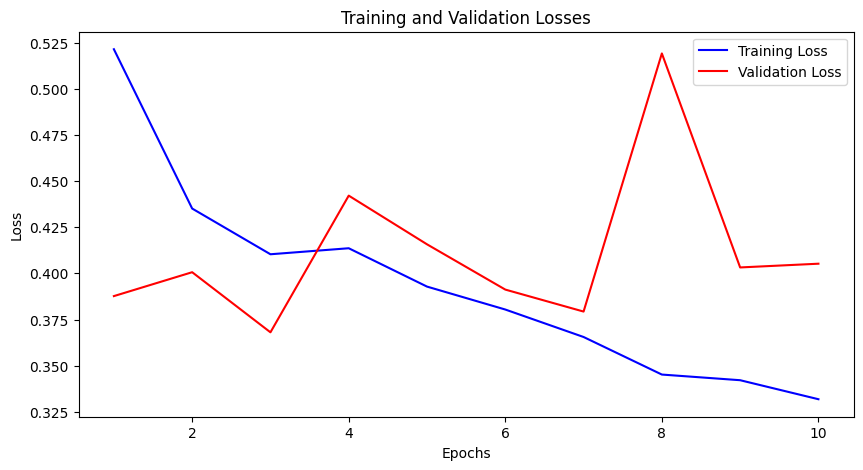

In [5]:
train_losses = []
val_losses = []

num_epochs = 10

# Training loop
best_val_loss = float('inf')
for epoch in tqdm(range(num_epochs), desc="Epochs", ncols=100):
    model.train()
    running_loss = 0.0

    # Training phase
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [6]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))

model.eval()
all_preds_prob = []
all_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs).squeeze()
        all_preds_prob.extend(outputs.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

auroc = roc_auc_score(all_labels, all_preds_prob)
print(f"Test AUROC: {auroc:.4f}")

Test AUROC: 0.8849
